In [23]:
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
# from tqdm import tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt
from utility import preprocess,get_dataset_loaders,Imputation_model,set_all_BN_layers_tracking_state,loss,impute_with_prediction

In [41]:
dataset_file = 'Spam.csv'
batch_size = 128
epoch = 200

In [3]:
trainX, testX, train_Mask, test_Mask, train_input, test_input, No, Dim = preprocess(dataset_file)

In [21]:
train_loader , test_loader = get_dataset_loaders(trainX, testX, train_Mask, test_Mask, train_input, test_input)

## 2 Pass

In [53]:
imputer = Imputation_model(Dim, Dim, Dim)
optimizer = torch.optim.Adam(params=imputer.parameters(),lr=0.0001)
losses = []
for it in tqdm(range(epoch)):
    imputer.train()

    batch_no = 0
    total_loss = 0.0  # Variable to accumulate the loss across all batches

    for truth_X, mask, data_X in train_loader:
        batch_no += 1

        set_all_BN_layers_tracking_state(imputer, False)
        optimizer.zero_grad()

        Imputer_loss = loss(truth=truth_X, mask=mask, data=data_X, imputer=imputer)[0]
        total_loss += Imputer_loss.item()  # Accumulate the loss for each batch
        Imputer_loss.backward()
        optimizer.step()

        set_all_BN_layers_tracking_state(imputer, True)
        prediction = loss(truth=truth_X, mask=mask, data=data_X, imputer=imputer)[1]
        imputed_data = impute_with_prediction(truth_X, mask, prediction)

        _ = imputer(imputed_data, mask)

        

    average_loss = total_loss / batch_no  # Calculate the average loss for the epoch
    # print('Iter: {}'.format(it), end='\t')
    # print('Train_loss: {:.4}'.format(np.sqrt(average_loss)))
    losses.append(average_loss)

100%|██████████| 200/200 [00:25<00:00,  7.95it/s]


In [54]:
with torch.no_grad():
    imputer.eval()
    MSE_total = []
    for truth_X, mask, data_X in test_loader:

        MSE, prediction =  loss(truth=truth_X, mask=mask, data=data_X,imputer = imputer )
        imputed_data = impute_with_prediction(truth_X, mask, prediction)
        MSE_total.append(MSE)
        #print('Test_loss: {:.4}'.format(np.sqrt(MSE.item())))

    #print([mse for mse in MSE_final]/len(MSE_final))

MSE_tensor = torch.tensor(MSE_total)
rmse_final = torch.sqrt(torch.mean(MSE_tensor))

print('Final Test RMSE: {:.4f}'.format(rmse_final.item()))

Final Test RMSE: 0.0681


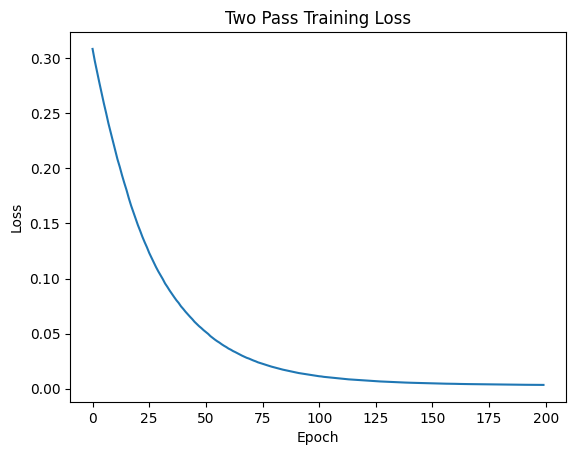

In [56]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Two Pass Training Loss')
plt.show()

## Single Pass

In [57]:
imputer = Imputation_model(Dim, Dim, Dim)
optimizer = torch.optim.Adam(params=imputer.parameters(),lr=0.0001)
losses = []
for it in tqdm(range(epoch)):
    imputer.train()

    batch_no = 0
    total_loss = 0.0  # Variable to accumulate the loss across all batches

    for truth_X, mask, data_X in train_loader:
        batch_no += 1

        set_all_BN_layers_tracking_state(imputer, True)
        optimizer.zero_grad()

        Imputer_loss = loss(truth=truth_X, mask=mask, data=data_X, imputer=imputer)[0]
        total_loss += Imputer_loss.item()  # Accumulate the loss for each batch
        Imputer_loss.backward()
        optimizer.step()

        # set_all_BN_layers_tracking_state(imputer, True)
        # prediction = loss(truth=truth_X, mask=mask, data=data_X, imputer=imputer)[1]
        # imputed_data = impute_with_prediction(truth_X, mask, prediction)

        # _ = imputer(imputed_data, mask)

        

    average_loss = total_loss / batch_no  # Calculate the average loss for the epoch
    # print('Iter: {}'.format(it), end='\t')
    # print('Train_loss: {:.4}'.format(np.sqrt(average_loss)))
    losses.append(average_loss)

100%|██████████| 200/200 [00:19<00:00, 10.29it/s]


In [58]:
with torch.no_grad():
    imputer.eval()
    MSE_total = []
    for truth_X, mask, data_X in test_loader:

        MSE, prediction =  loss(truth=truth_X, mask=mask, data=data_X,imputer = imputer )
        imputed_data = impute_with_prediction(truth_X, mask, prediction)
        MSE_total.append(MSE)
        #print('Test_loss: {:.4}'.format(np.sqrt(MSE.item())))

    #print([mse for mse in MSE_final]/len(MSE_final))

MSE_tensor = torch.tensor(MSE_total)
rmse_final = torch.sqrt(torch.mean(MSE_tensor))

print('Final Test RMSE: {:.4f}'.format(rmse_final.item()))

Final Test RMSE: 0.0644
